
================= MONTE CARLO SIMULATION OF THE PORTFOLIO =================

------------------------------
Outlook: 10 years
Number of Simulations: 10000
------------------------------

 Portfolio Composition:

 Ticker Percentage
    VOO     35.00%
    QQQ     35.00%
ZPRV.DE     15.00%
   VXUS     15.00%

------ HISTORICAL DATA ------
Avg Daily Return: 0.000506
Daily Volatility: 0.011254
-----------------------------

----- SIMULATION RESULTS (10 YEARS) -----
Initial Investment: $1,000.00
Median Final Value: $3,597.92
Mean Final Value:   $4,244.88
Worst Case (5%):    $1,383.55
Best Case (95%):    $9,338.81
-----------------------------------------


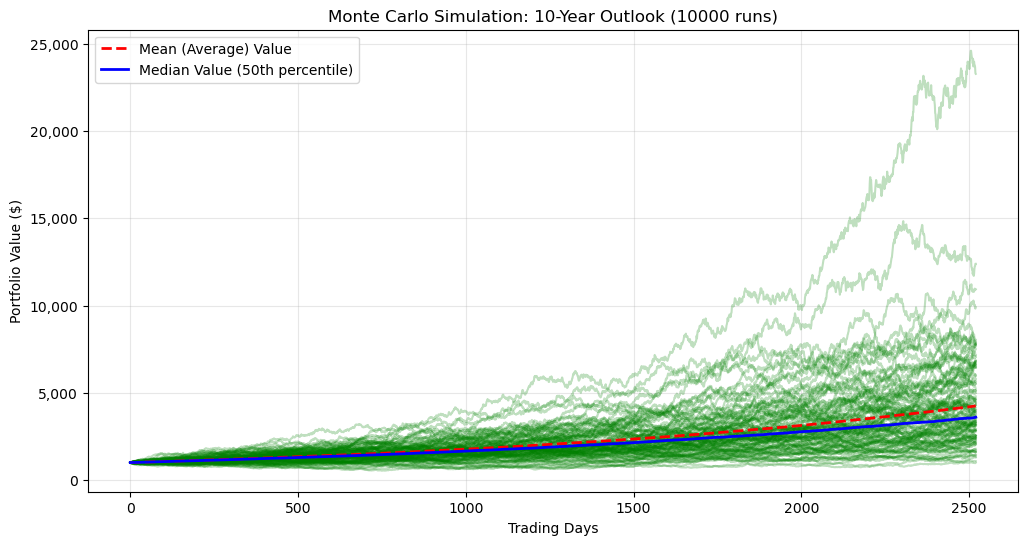

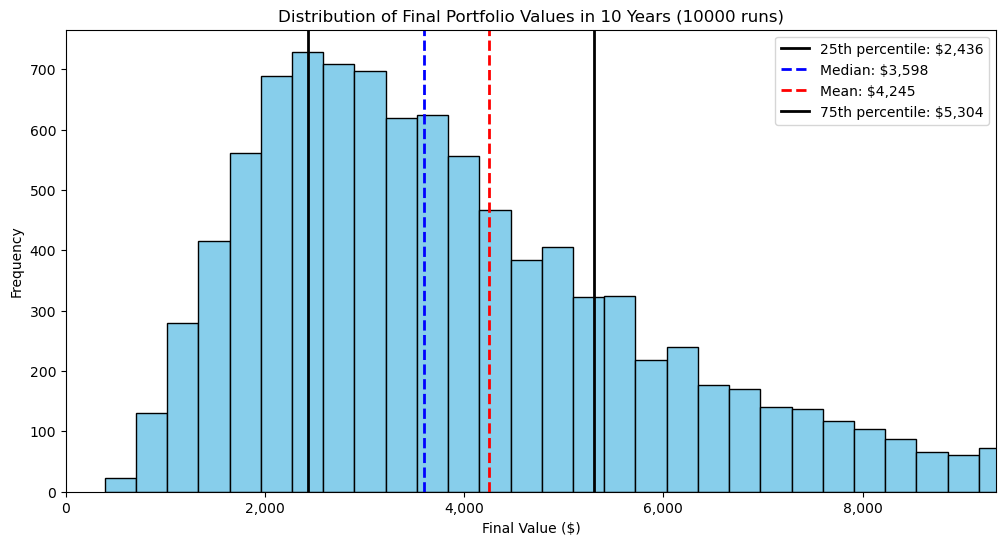

In [6]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

                        ## Parameters Selection + Data Import

# Parameters that have to be set
tickers = ['VOO', 'QQQ', 'ZPRV.DE', 'VXUS']
comp = [0.35, 0.35, 0.15, 0.15]
initial = 1000
years_history = 15

# Simulation Parameters
years = 10
trading_days = 252
n_simulations = 10000

# If any stock is traded on non-US exchange, specify the ticker and the currency pair in a format as follows: 'RHM.DE': 'EURUSD=X'. 
# All the other currencies have to be converted to USD.
fx_pairs = {'ZPRV.DE': 'EURUSD=X'}

                        ## Definition of Functions

# Import data using Yahoo Finance API
def get_data(tickers, fx_pairs, years_back):

    fx_tickers = list({v for v in fx_pairs.values()})
    all_tickers = tickers + fx_tickers
    
    start_date = pd.to_datetime('today') - pd.DateOffset(years = years_back)
    end_date = pd.to_datetime('today')

    raw_data = yf.download(
        all_tickers, 
        start = start_date, 
        end = end_date, 
        group_by = 'ticker', 
        auto_adjust = True, 
        progress = False,
        threads = True
    )

    try:
        df_close = raw_data.xs('Close', level=1, axis=1).copy()

    except KeyError:
        # Two possibilities exist: first layer is a ticker, or a price 'type' (i.e. 'Close'). 
        # This failsafe ensures that correct data will be obtained either way
        if 'Close' in raw_data.columns.get_level_values(0):
            df_close = raw_data['Close'].copy()
        else:
            df_close = raw_data.copy()

        # Different stock markets have different holidays, so a certain misalignment is possible. This line is here to prevent it. 
        # If a cell in a DataFrame is Null, ffill fills with a values that coresponds to a previous day
        df_close = df_close.ffill().bfill()

    for ticker, fx_pair in fx_pairs.items():
        if ticker in df_close.columns and fx_pair in df_close.columns:
            df_close[ticker] = df_close[ticker] * df_close[fx_pair]
    
    return df_close[tickers]

def run_monte_carlo(prices, weights, n_simulations, years):

    # Calculate Daily Log Returns. Logarithmic return is better for long term simulations
    log_returns = np.log(prices/prices.shift(1)).dropna()

    # Ensure weights sum to exactly 1.0
    weights = np.array(comp)
    weights /= weights.sum()

    # Calculate Portfolio Daily Drift (Mean)
    daily_drift = np.sum(log_returns.mean() * weights)

    # Calculate Portfolio Volatility (Standard Deviation)
    cov_matrix = log_returns.cov()
    portfolio_std_dev = np.sqrt(np.dot(weights, np.dot(cov_matrix, weights)))

    # Total number of trading days during the simulated period
    total_days = int(years * trading_days)

    # Generate Random Z-Scores
    Z = np.random.normal(0, 1, (total_days, n_simulations)).astype(np.float32)

    # Calculate daily returns for all simulations
    # (drift + shock(Z))
    daily_sim_returns = daily_drift + (portfolio_std_dev * Z)

    # Accumulate returns
    cumulative_returns = np.cumsum(daily_sim_returns, axis=0)

    # Apply to Initial Portfolio Value
    # We add [0] row at the top to represent the starting day (Day 0 = Initial Value)
    portfolio_simulations = initial * np.exp(cumulative_returns)
    portfolio_simulations = np.vstack([np.full((1, n_simulations), initial), portfolio_simulations])

    return portfolio_simulations, daily_drift, portfolio_std_dev

                        ## Execution

df_prices = get_data(tickers, fx_pairs, years_history)

paths, avg_return, std_dev = run_monte_carlo(df_prices, comp, n_simulations, years)

                        ## Final result and viz

# Extract results of the last day of the sim
final_values = paths[-1, :]

# Calculate Key Statistical parameters
expected_value = np.mean(final_values)
median_value = np.median(final_values)
# The worst case, bottom 5% 
worst_case = np.percentile(final_values, 5)   
# The best case, top 5%
best_case = np.percentile(final_values, 95)

df_initial_portfolio = pd.DataFrame({'Ticker': tickers,
                             'Percentage': comp
})

df_initial_portfolio = df_initial_portfolio.sort_values('Percentage', ascending = False)
df_initial_portfolio['Percentage'] = df_initial_portfolio['Percentage'] * 100
df_initial_portfolio['Percentage'] = df_initial_portfolio['Percentage'].map('{:.2f}%'.format)

print("\n================= MONTE CARLO SIMULATION OF THE PORTFOLIO =================\n")
print("------------------------------")
if years == 1:
    print(f"Outlook: {years} year")
else: 
    print(f"Outlook: {years} years") 
print(f"Number of Simulations: {n_simulations}")
print("------------------------------")
print("\n Portfolio Composition:\n")
print(df_initial_portfolio.to_string(index=False))

print(f"\n------ HISTORICAL DATA ------")
print(f"Avg Daily Return: {avg_return:.6f}")
print(f"Daily Volatility: {std_dev:.6f}")
print(f"-----------------------------")

if years == 1:
    print(f"\n----- SIMULATION RESULTS ({years} YEAR) -----")
else:
    print(f"\n----- SIMULATION RESULTS ({years} YEARS) -----")
print(f"Initial Investment: ${initial:,.2f}")
print(f"Median Final Value: ${median_value:,.2f}")
print(f"Mean Final Value:   ${expected_value:,.2f}")
print(f"Worst Case (5%):    ${worst_case:,.2f}")
print(f"Best Case (95%):    ${best_case:,.2f}")
print("-----------------------------------------")

plt.figure(figsize=(12, 6))

# Plot only the first 100 simulations to keep the chart readable
plt.plot(paths[:, :100], color='green', alpha=0.25)

# Plot Mean and Median values
plt.plot(np.mean(paths, axis=1), 'r--', linewidth=2, label='Mean (Average) Value')
plt.plot(np.median(paths, axis=1), 'b-', linewidth=2, label='Median Value (50th percentile)')
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.title(f'Monte Carlo Simulation: {years}-Year Outlook ({n_simulations} runs)')
plt.xlabel('Trading Days')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Histogram of final results
plt.figure(figsize=(12, 6))
plt.xlim(left = 0, right = np.percentile(final_values, 95))
plt.hist(final_values, bins=100, color='skyblue', edgecolor='black')
plt.gca().xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.axvline(np.percentile(final_values, 25), color='black', linestyle='solid', linewidth=2, label=f'25th percentile: ${np.percentile(final_values, 25):,.0f}')
plt.axvline(median_value, color='b', linestyle='dashed', linewidth=2, label=f'Median: ${median_value:,.0f}')
plt.axvline(expected_value, color='r', linestyle='dashed', linewidth=2, label=f'Mean: ${expected_value:,.0f}')
plt.axvline(np.percentile(final_values, 75), color='black', linestyle='solid', linewidth=2, label=f'75th percentile: ${np.percentile(final_values, 75):,.0f}')
if years == 1:
        plt.title(f'Distribution of Final Portfolio Values in {years} Year ({n_simulations} runs)')
else: 
        plt.title(f'Distribution of Final Portfolio Values in {years} Years ({n_simulations} runs)')
plt.xlabel('Final Value ($)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [19]:
tickers = ["ASML", "BKNG", "MSFT", "GOOG", "AAPL", "ORCL", "NVDA", "VOO", "QQQ", "V", "MA", "KO", "PEP"]

test = yf.download(tickers, start = '2000-01-01', end = end_date, interval = '1d', group_by = 'ticker', auto_adjust = True, threads = True)
test_final = test.xs('Close', axis = 1, level = 1)
test_final

[*********************100%***********************]  13 of 13 completed


Ticker,ORCL,AAPL,GOOG,ASML,MSFT,BKNG,VOO,KO,V,QQQ,MA,PEP,NVDA
Date,,,,,,,,,,,,,
2000-01-03,23.673817,0.839281,NaN,36.582329,35.601433,302.549469,NaN,13.614951,NaN,80.131348,NaN,18.982489,0.089415
2000-01-04,21.581997,0.768521,NaN,34.146130,34.398823,318.783875,NaN,13.630044,NaN,74.634178,NaN,18.499872,0.087028
2000-01-05,20.442150,0.779767,NaN,33.203083,34.761528,353.835327,NaN,13.750796,NaN,72.731308,NaN,18.049444,0.084163
2000-01-06,19.239670,0.712287,NaN,31.159817,33.597088,339.445770,NaN,13.765891,NaN,67.736336,NaN,18.853786,0.078671
2000-01-07,20.717714,0.746027,NaN,31.867102,34.036125,337.969940,NaN,14.671541,NaN,76.114166,NaN,19.368570,0.079985
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-04,214.330002,280.700012,318.182434,1110.079956,480.839996,5017.600098,629.299988,70.449997,327.100006,622.940002,542.309998,145.487000,183.380005
2025-12-05,217.580002,278.779999,321.879974,1099.469971,483.160004,5197.040039,630.479980,70.000000,331.239990,625.479980,545.520020,145.020004,182.410004
2025-12-08,220.539993,277.890015,314.450012,1119.689941,491.019989,5177.390137,628.609985,70.250000,326.839996,624.280029,540.440002,145.630005,185.550003
